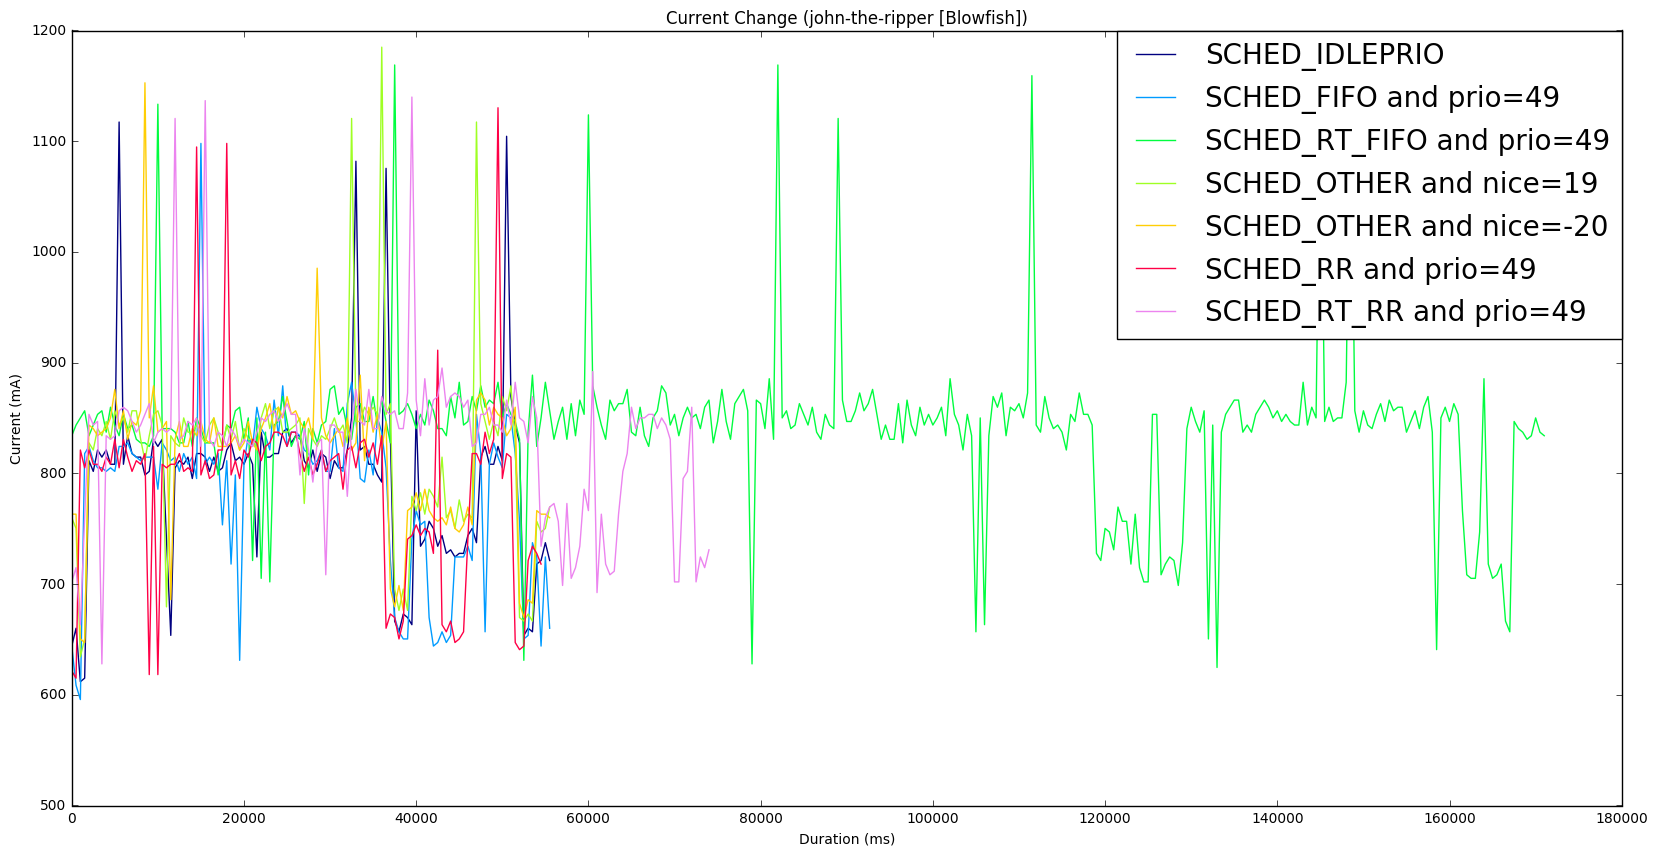

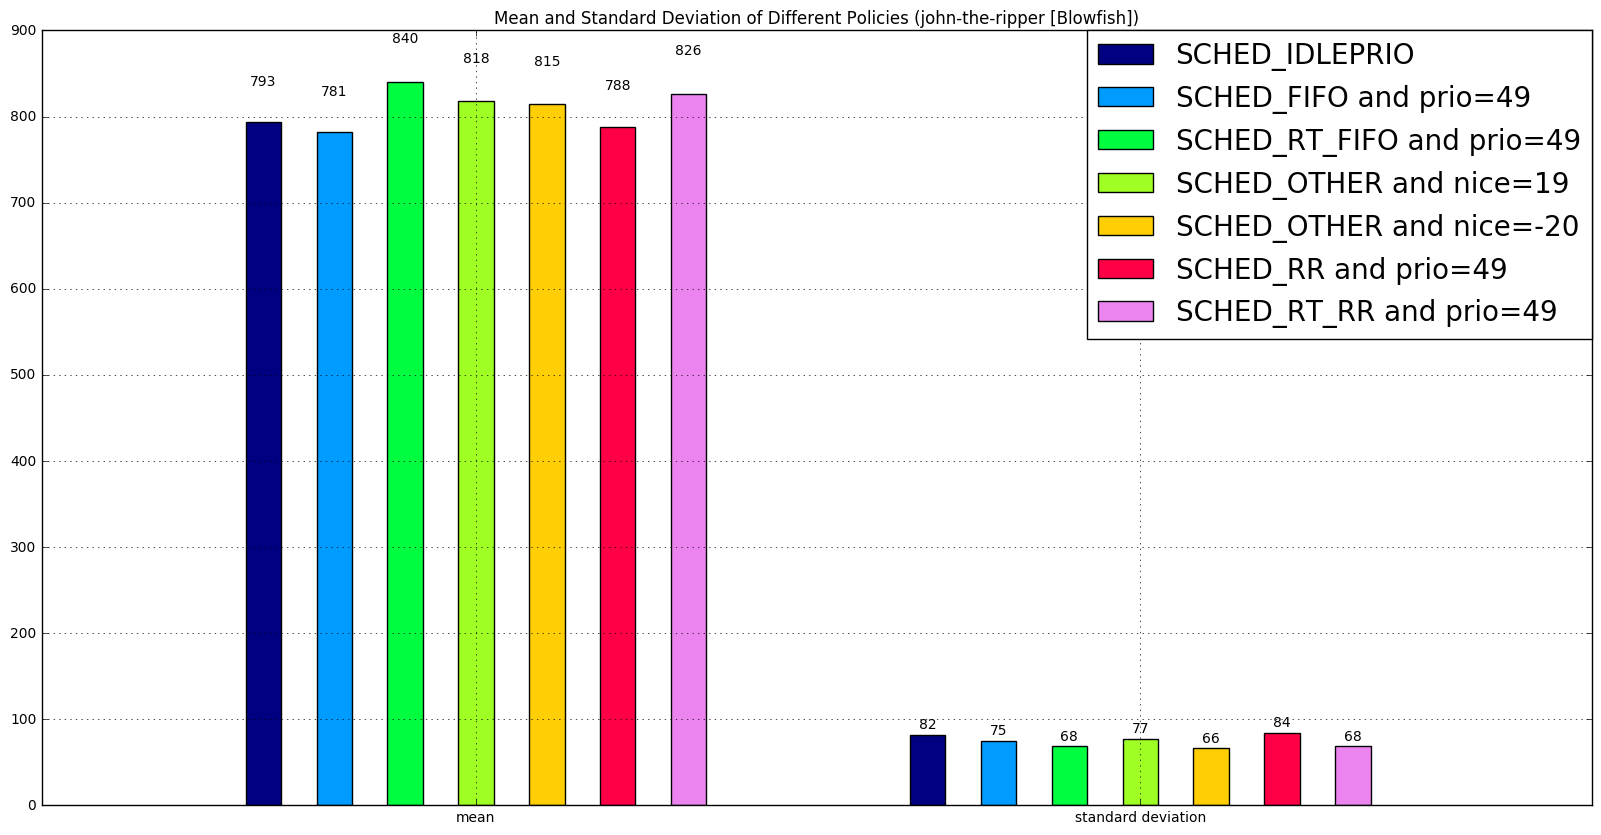

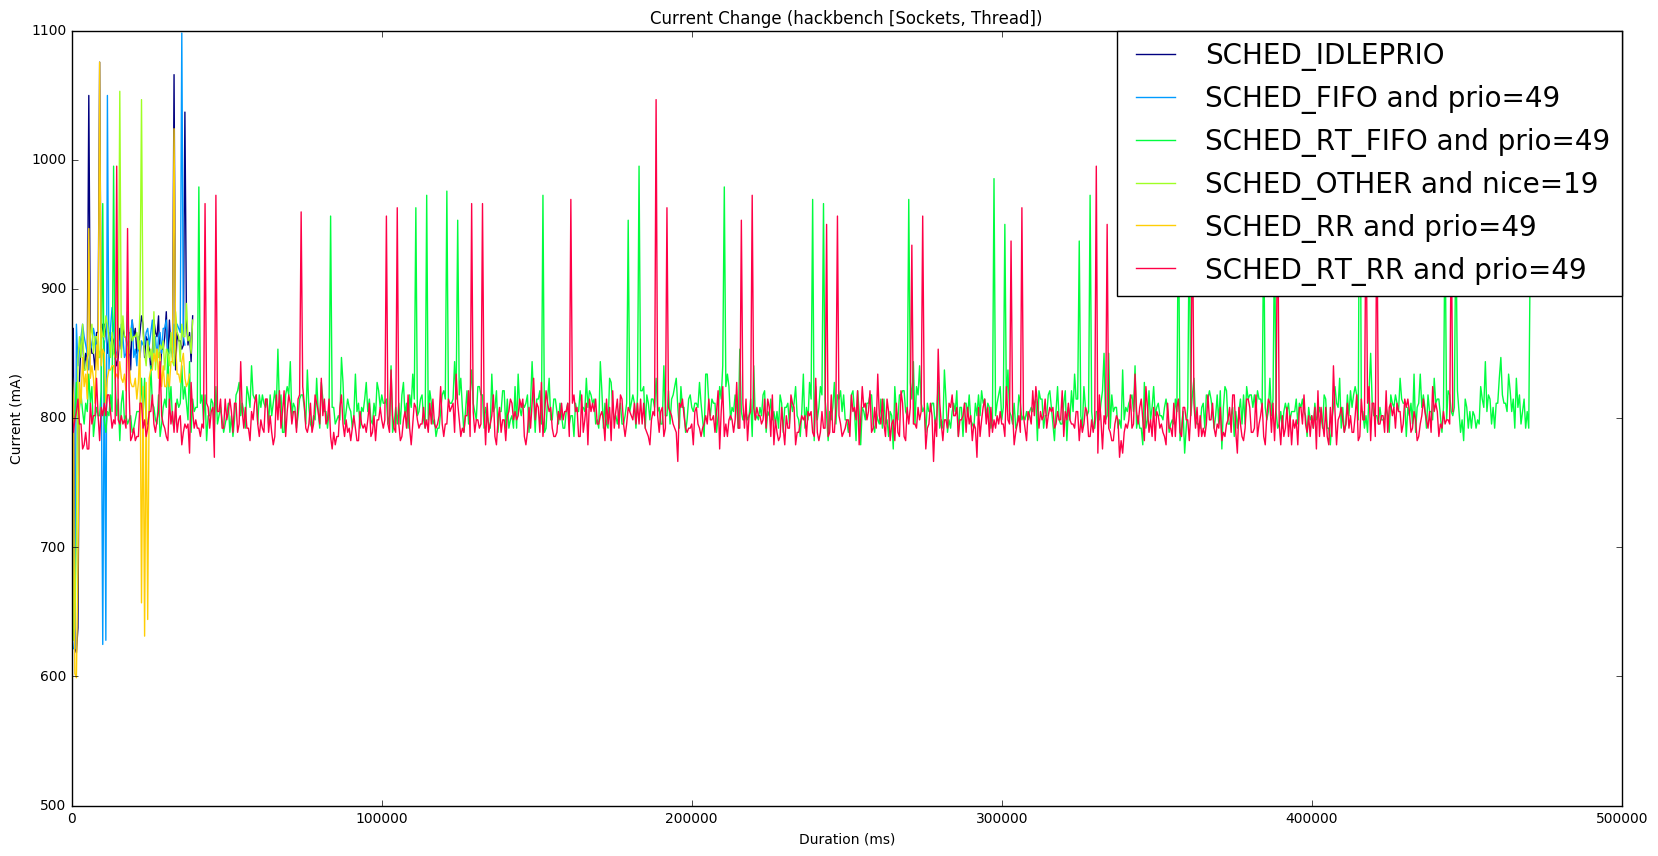

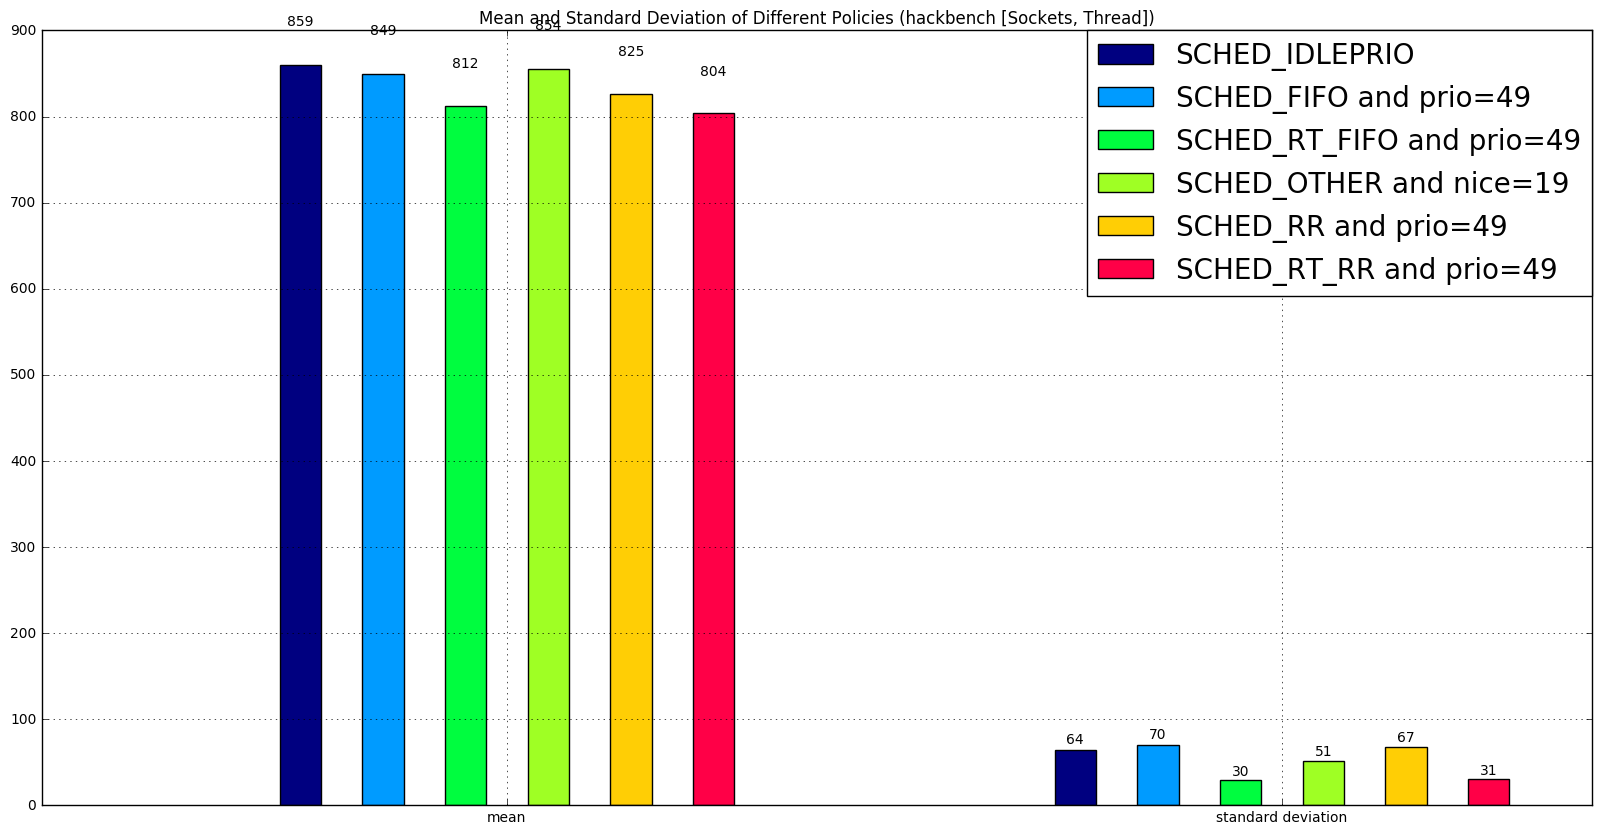

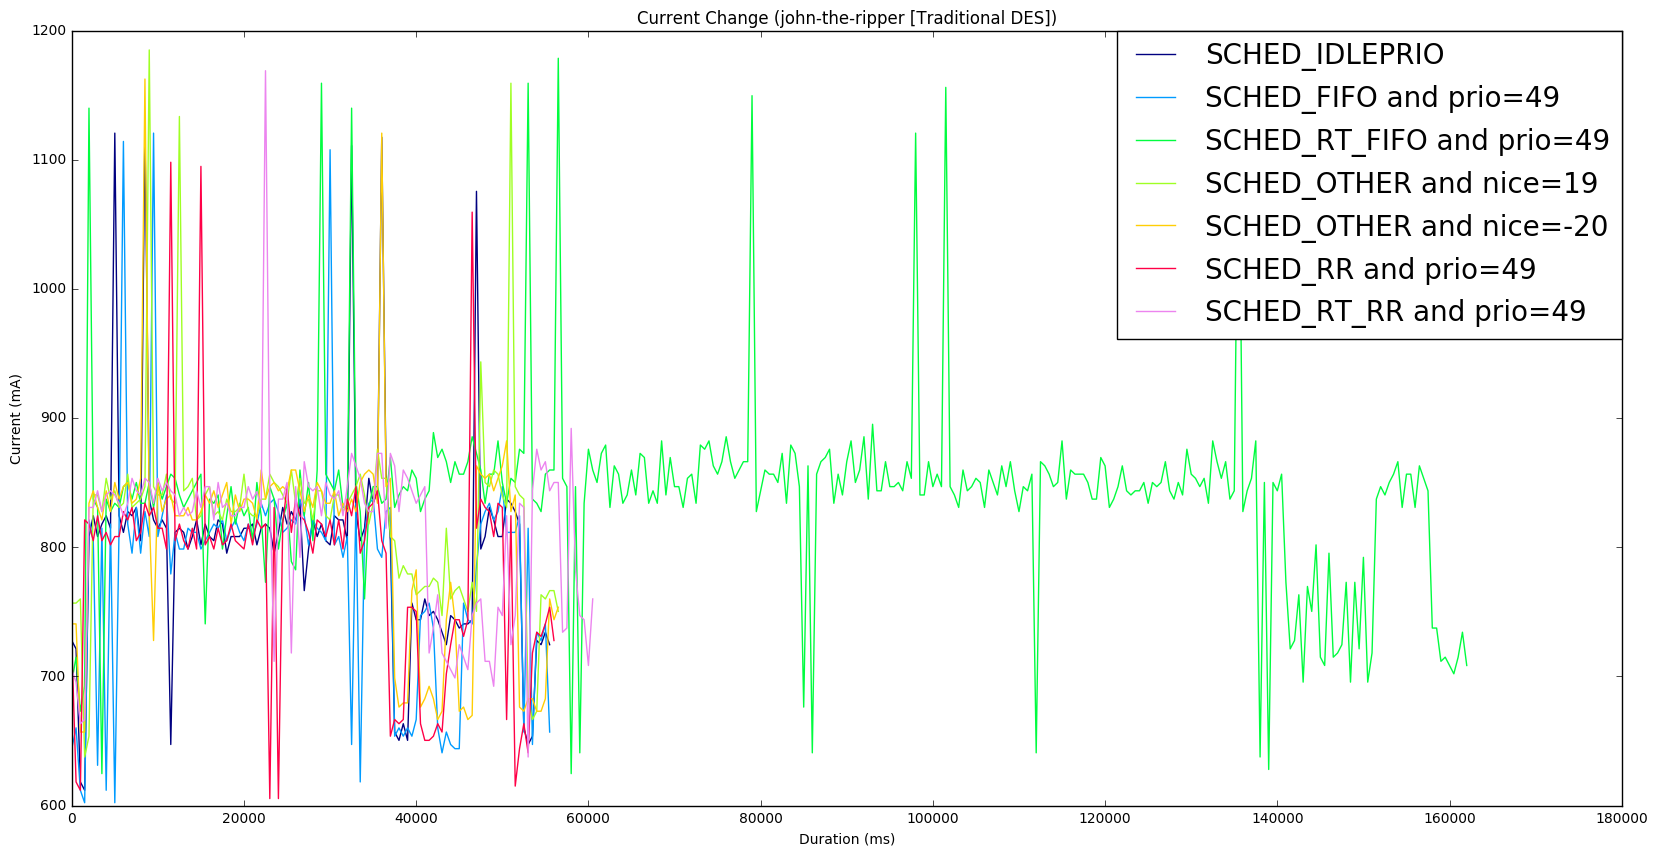

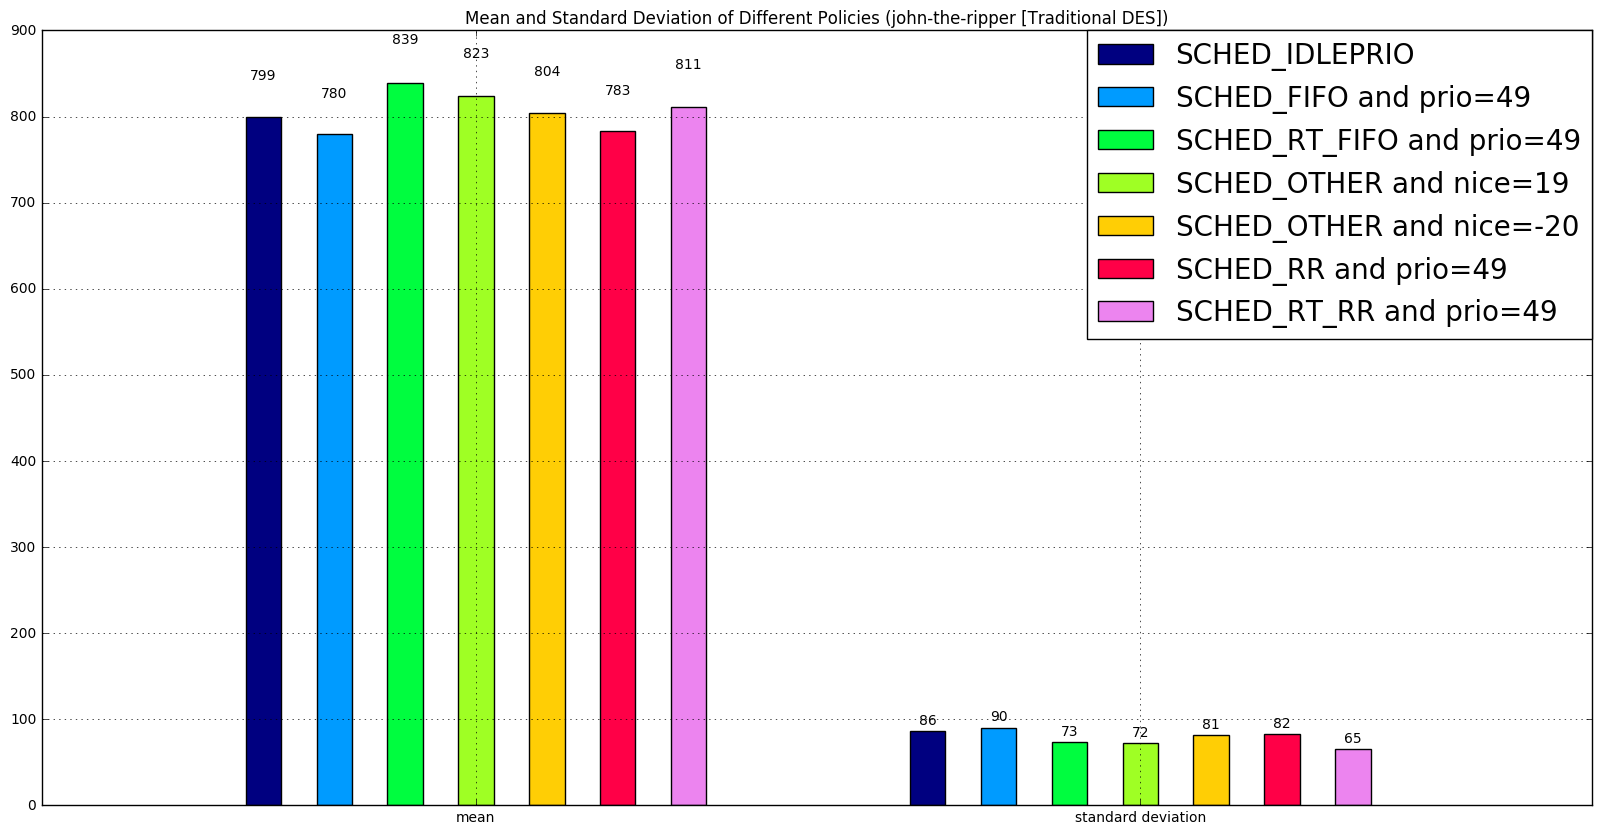

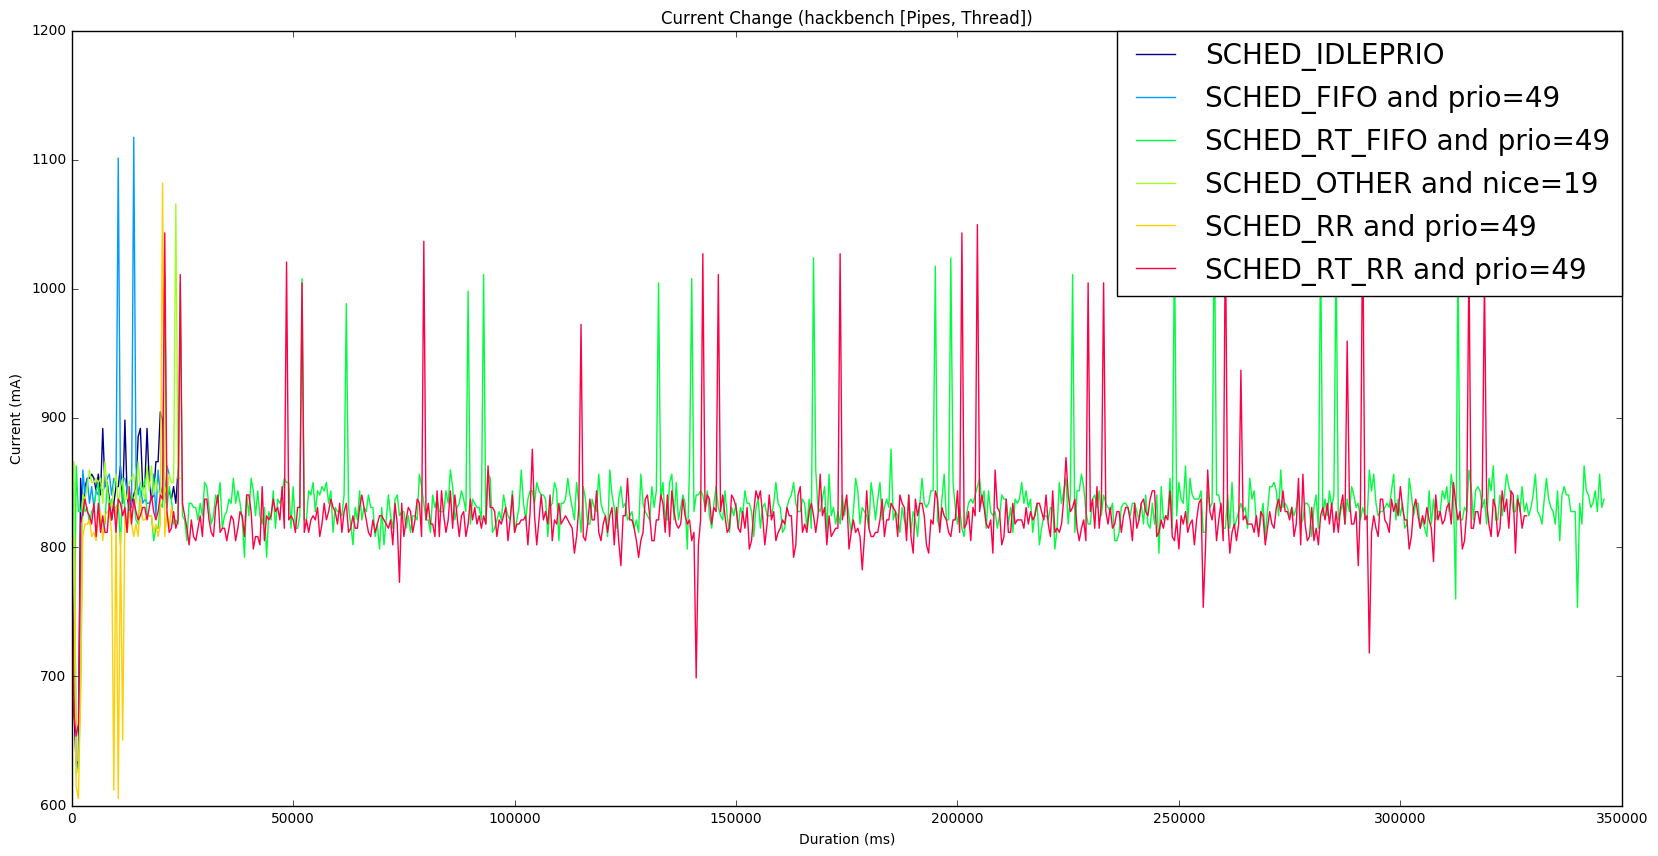

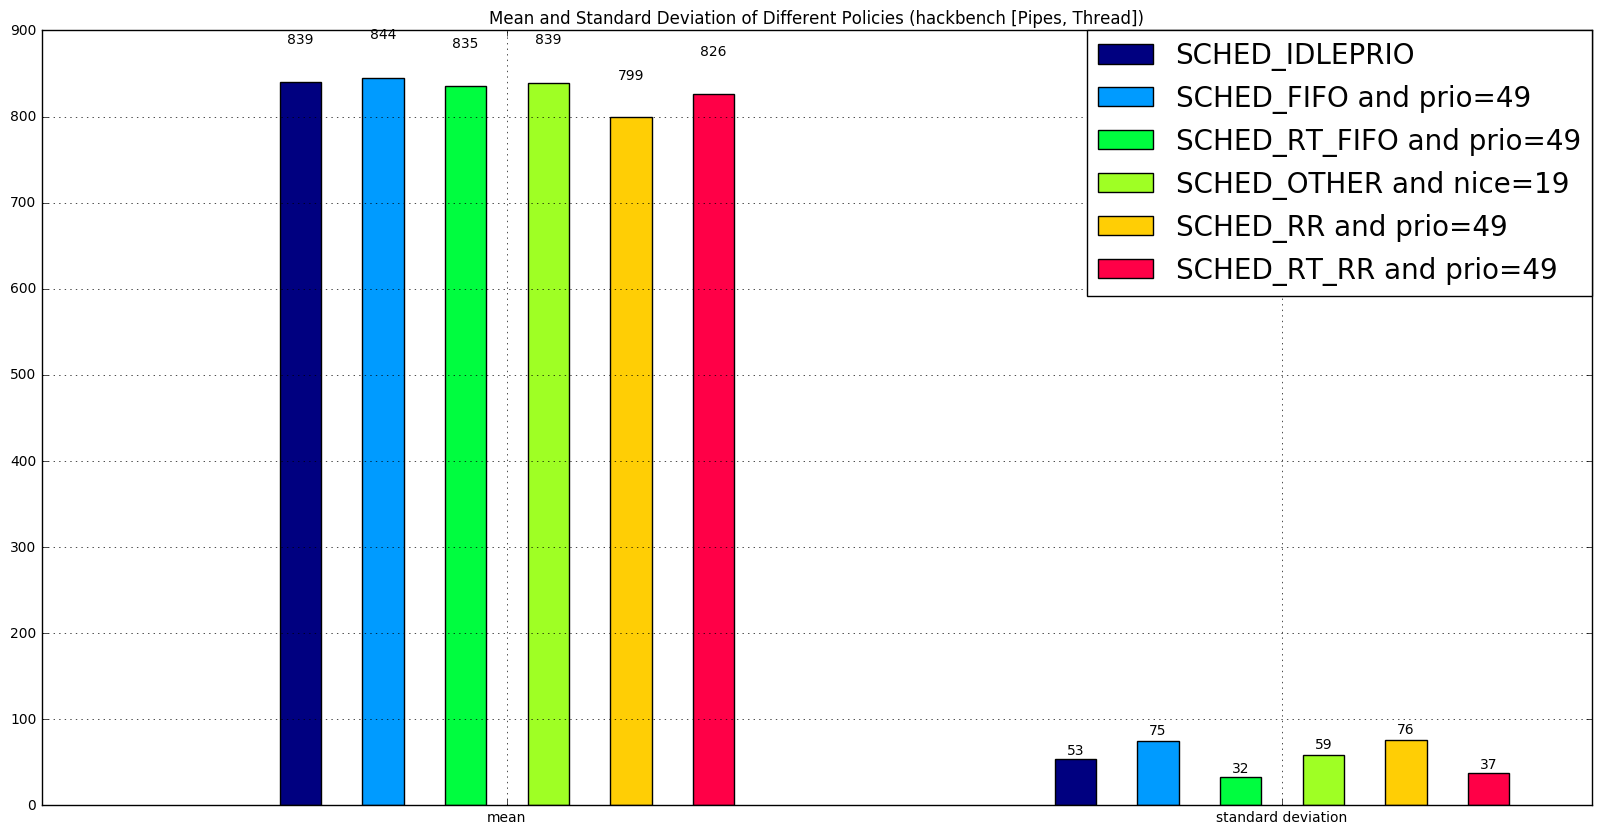

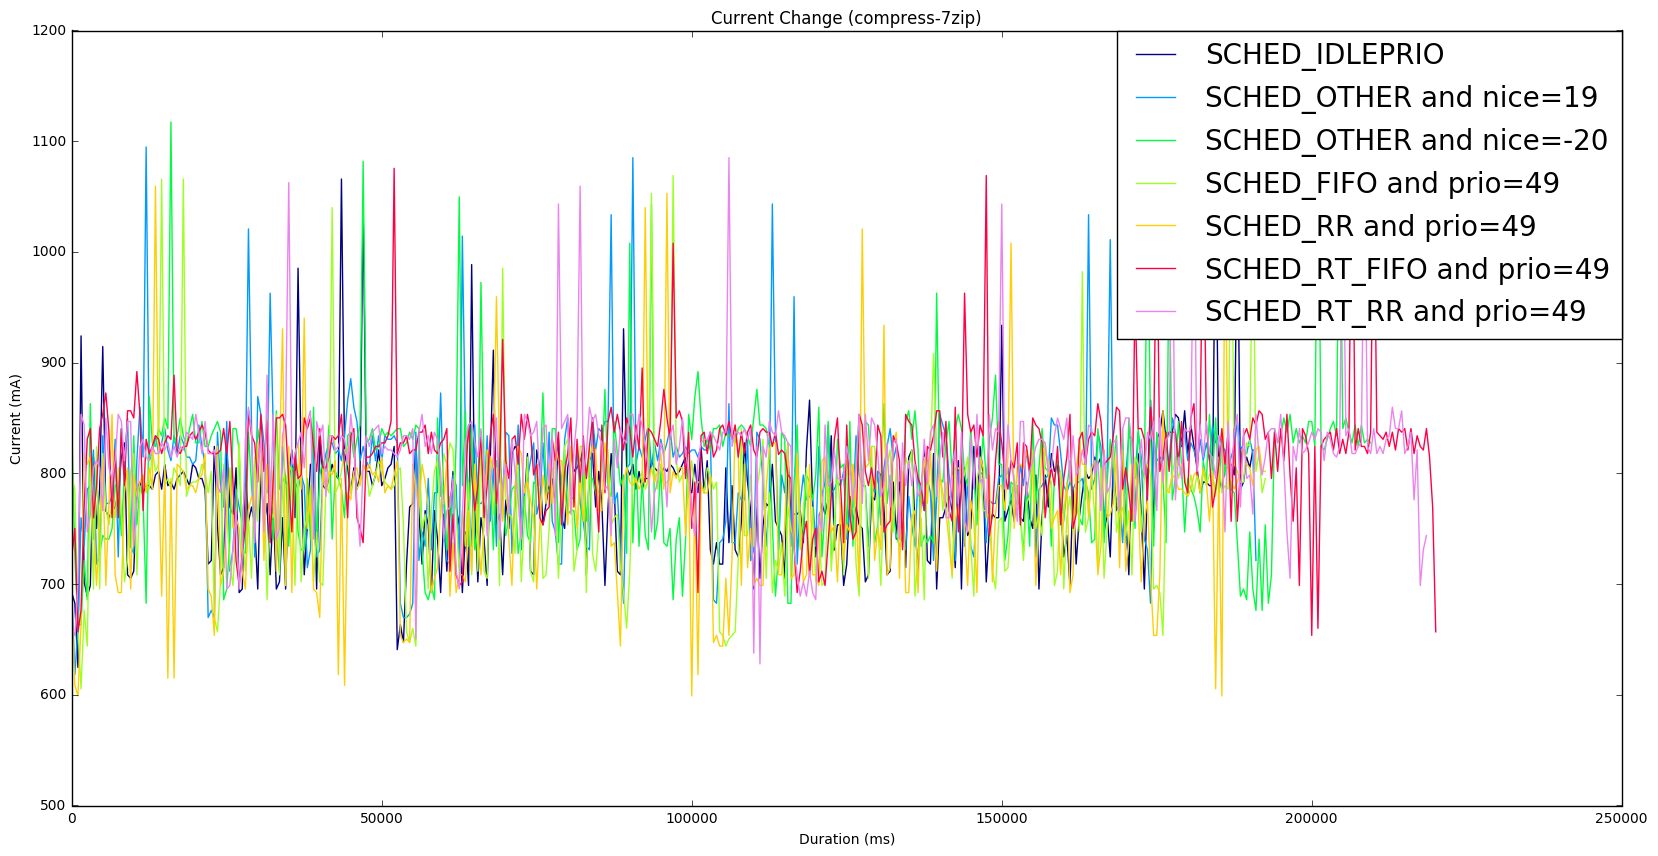

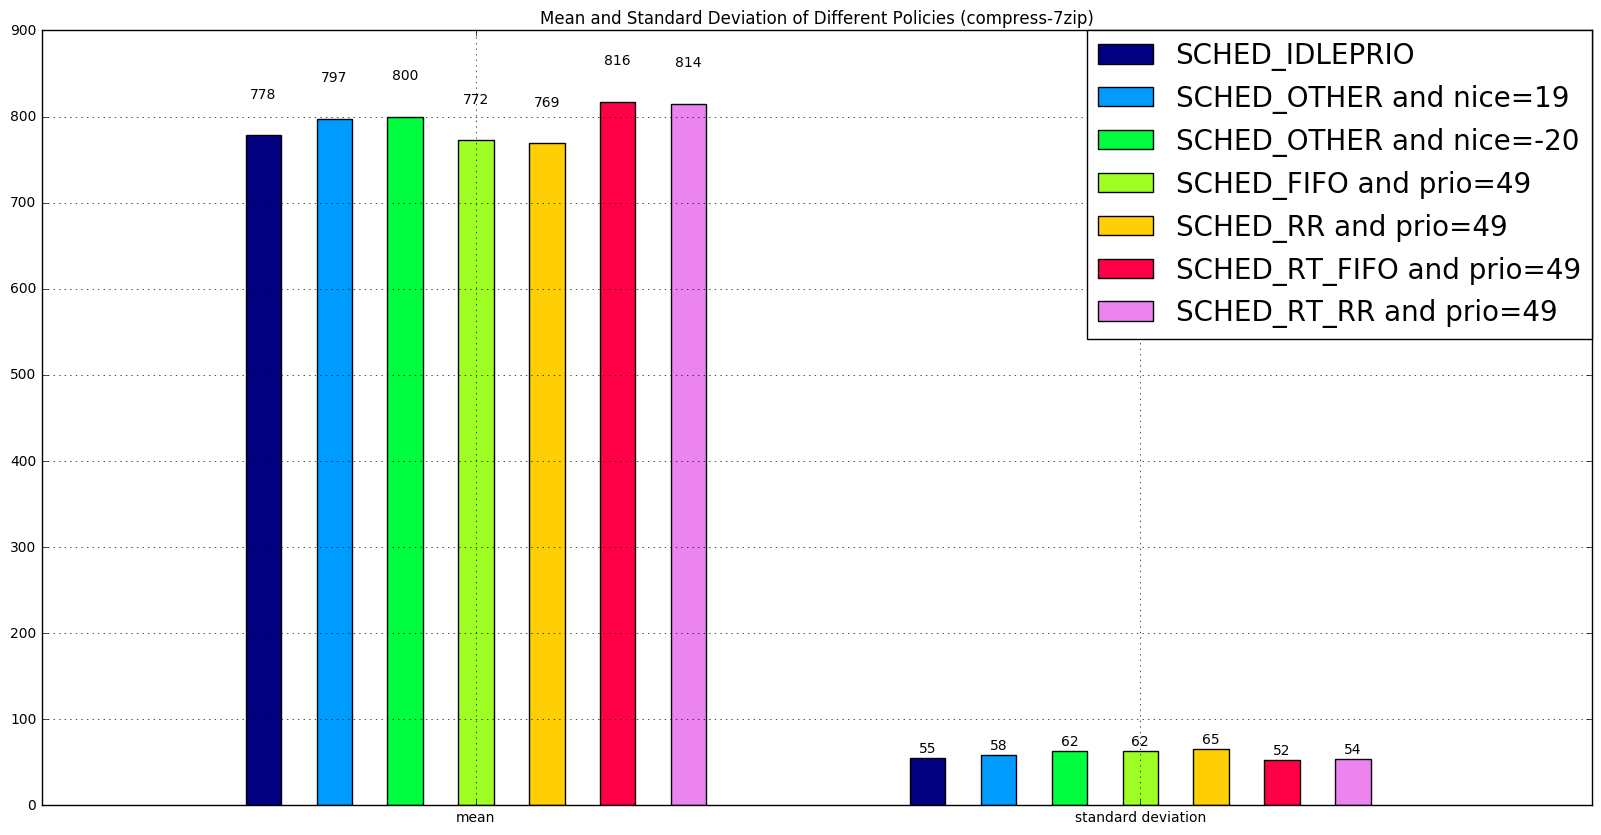

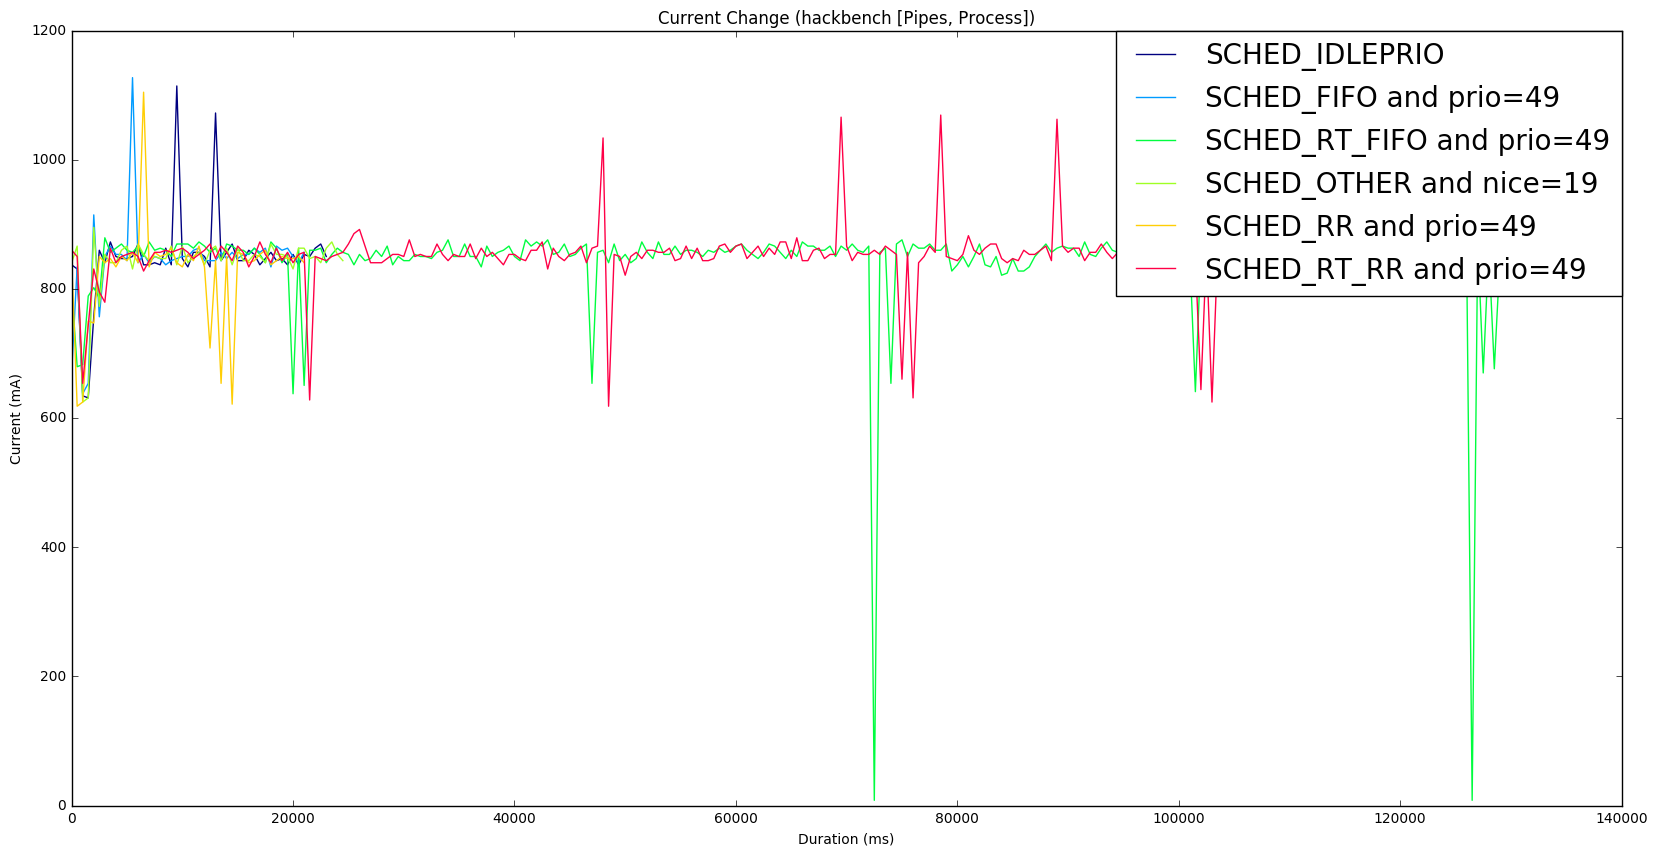

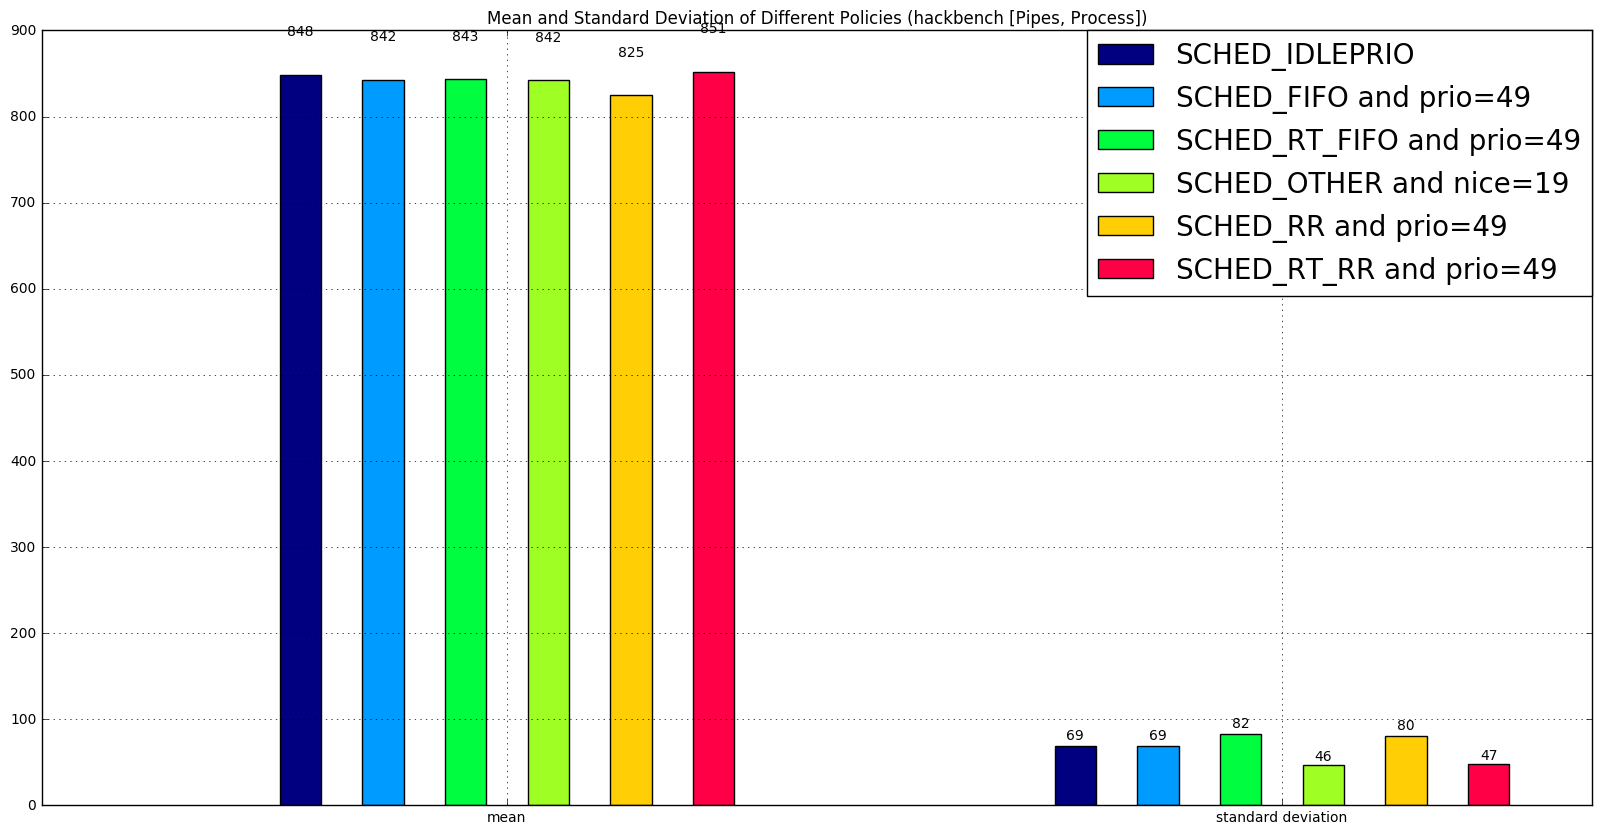

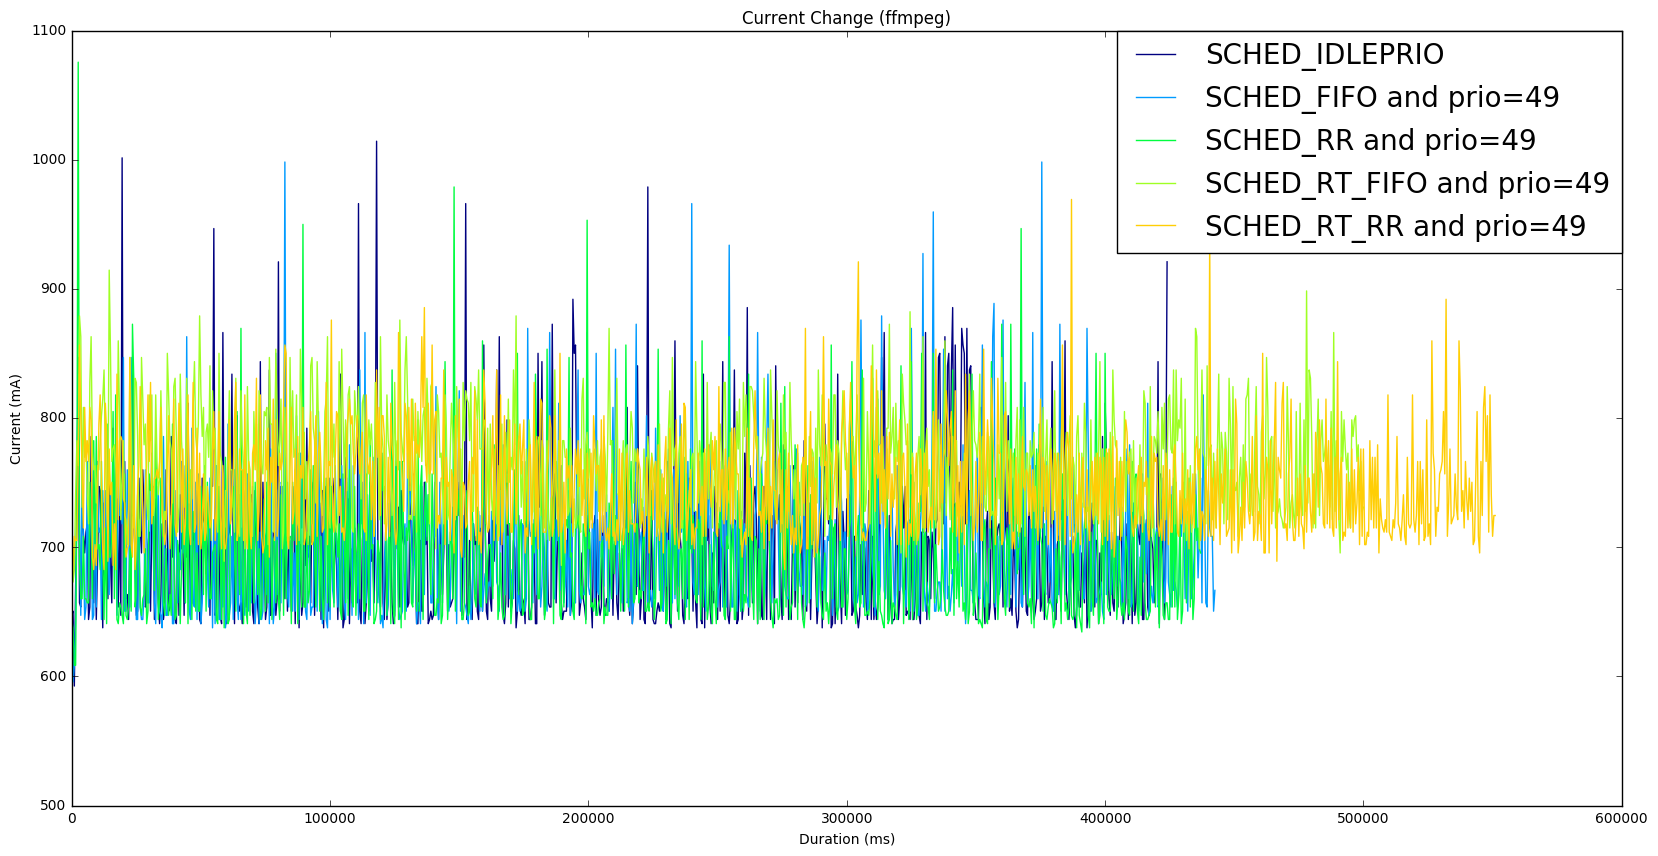

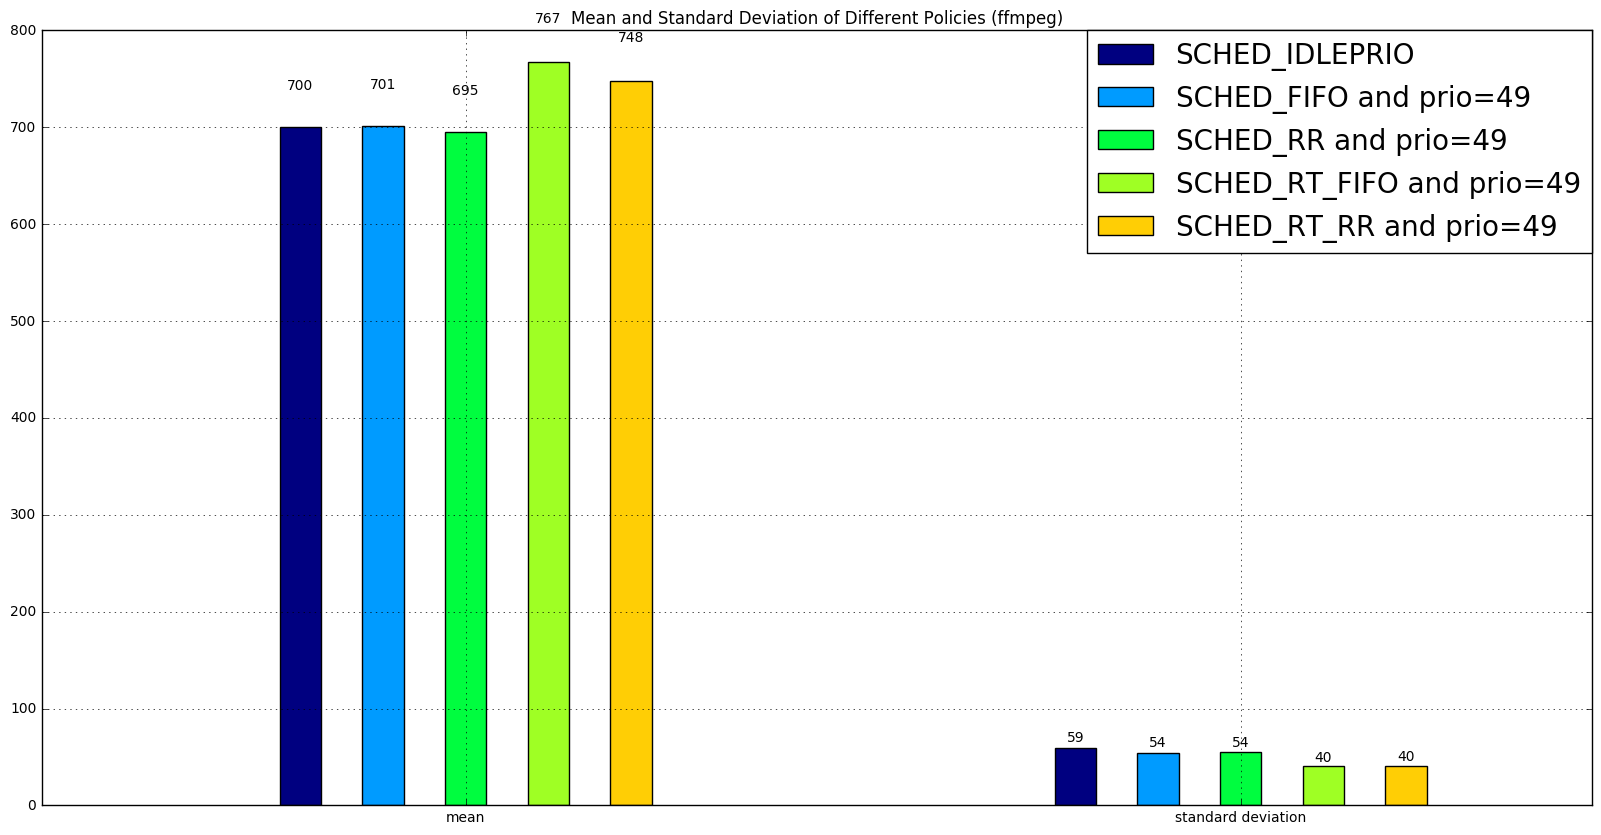

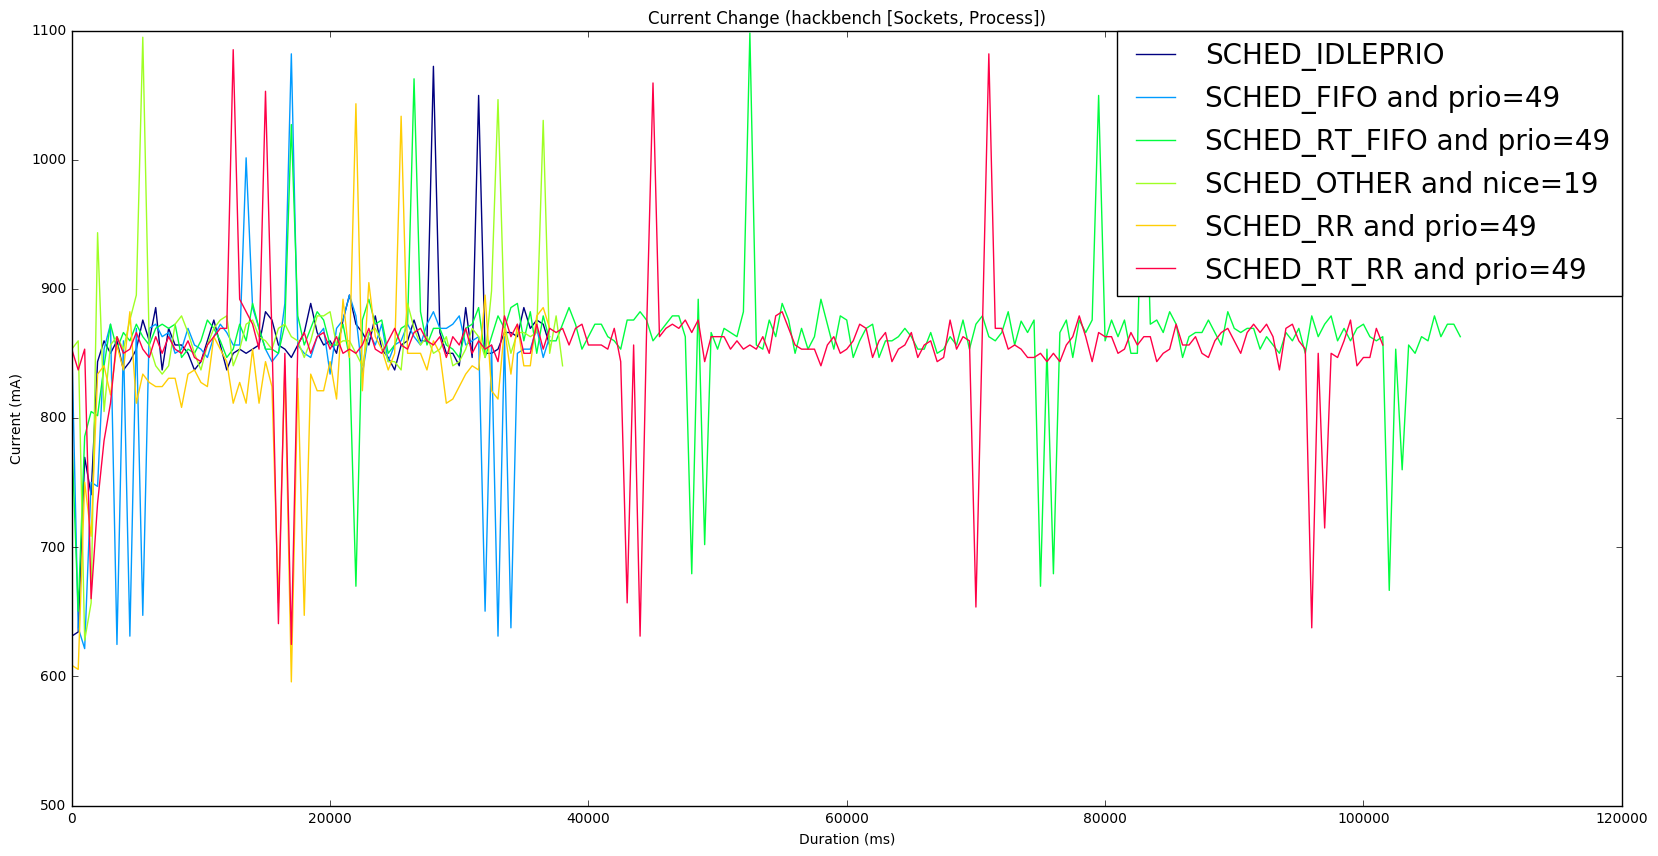

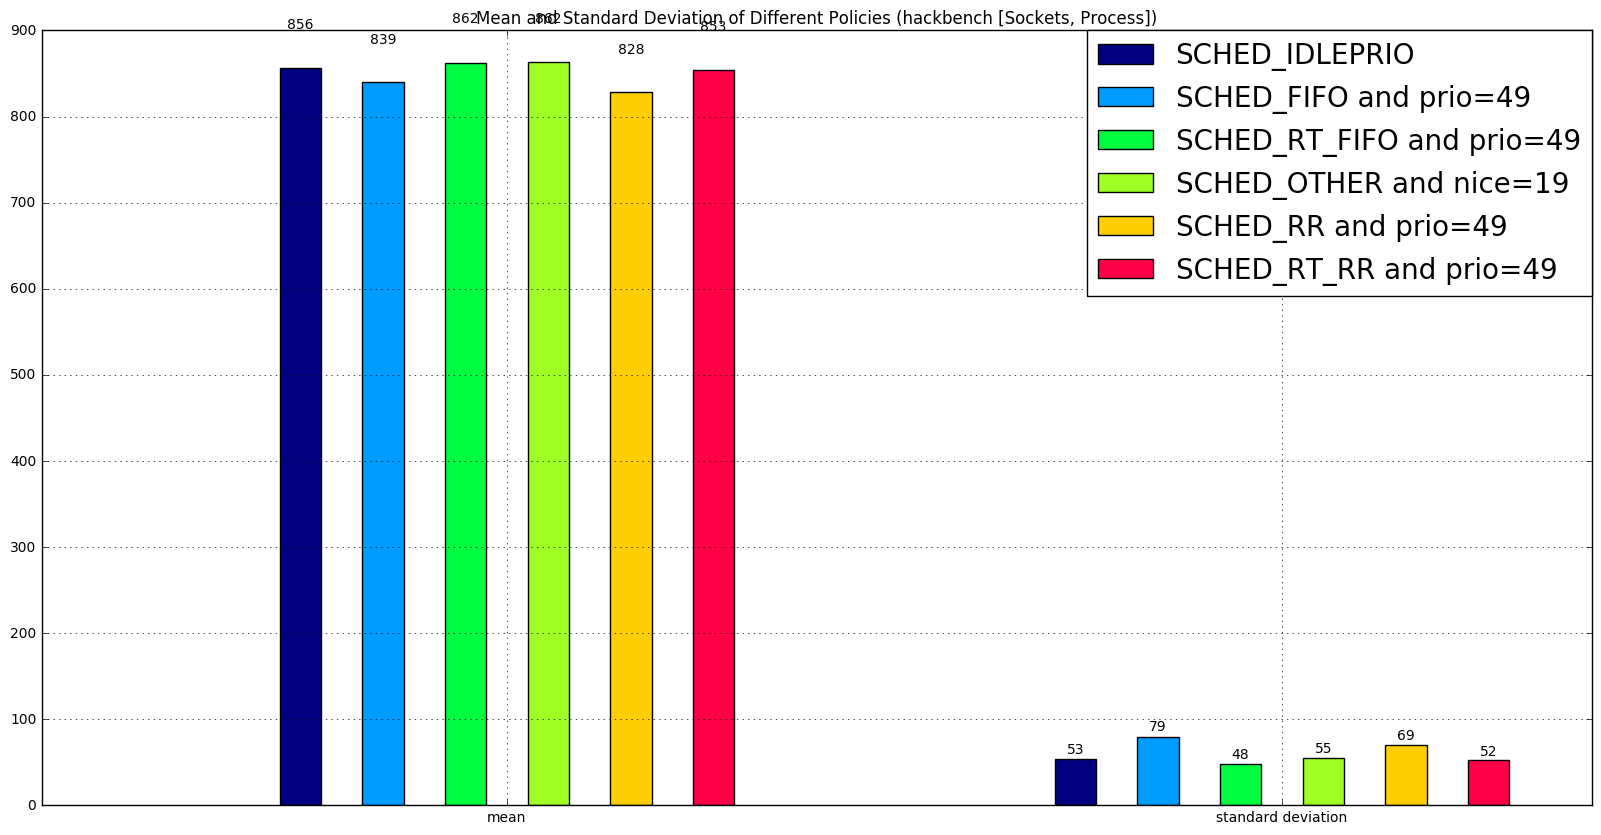

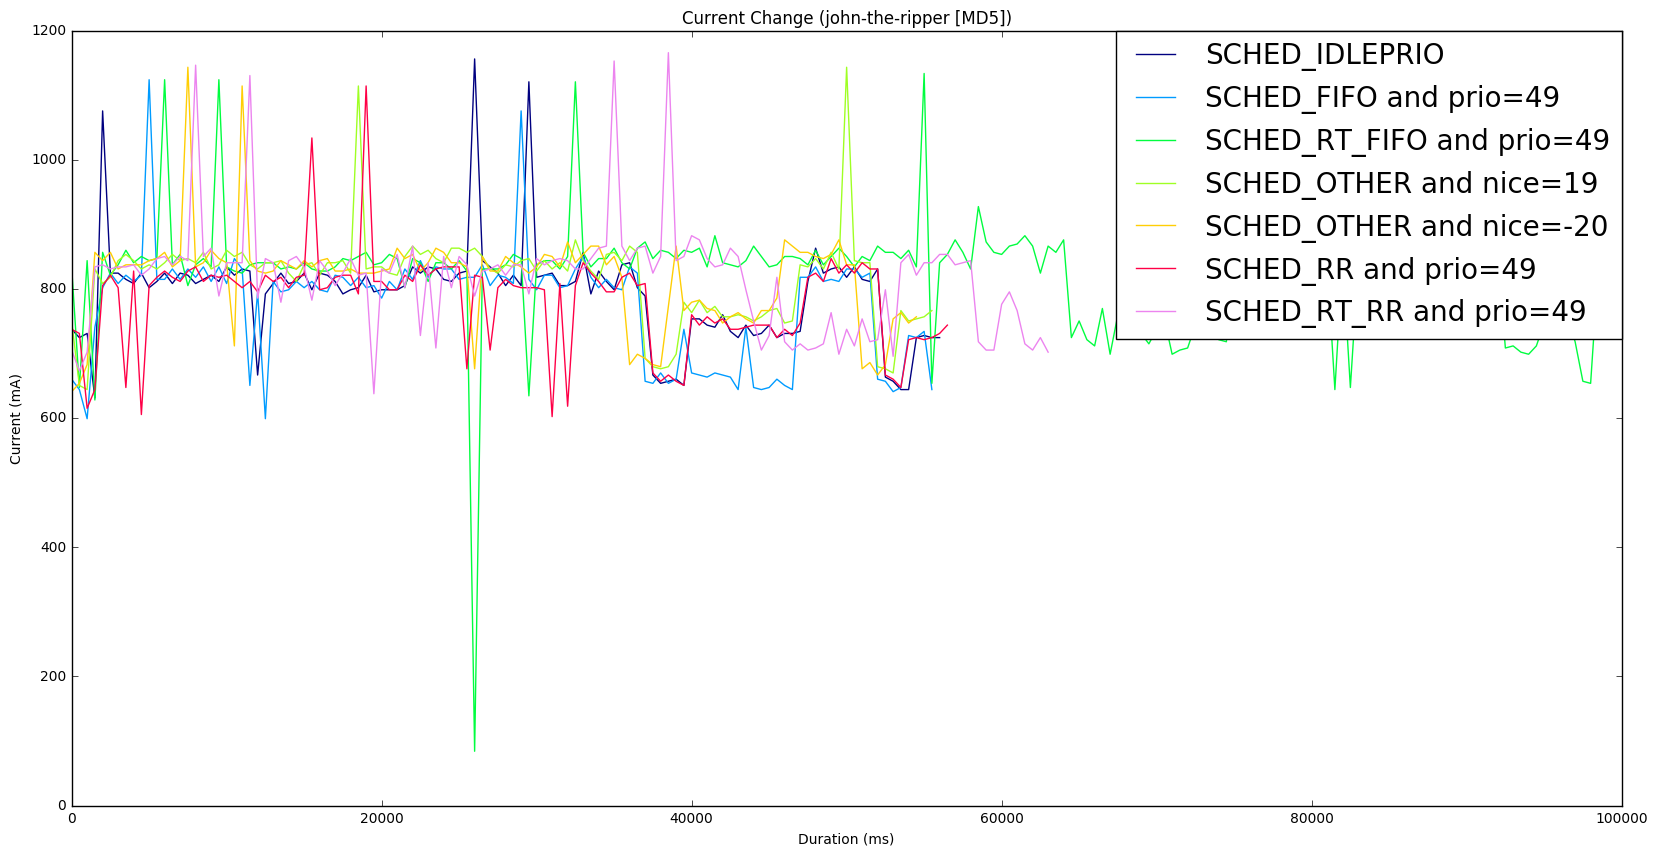

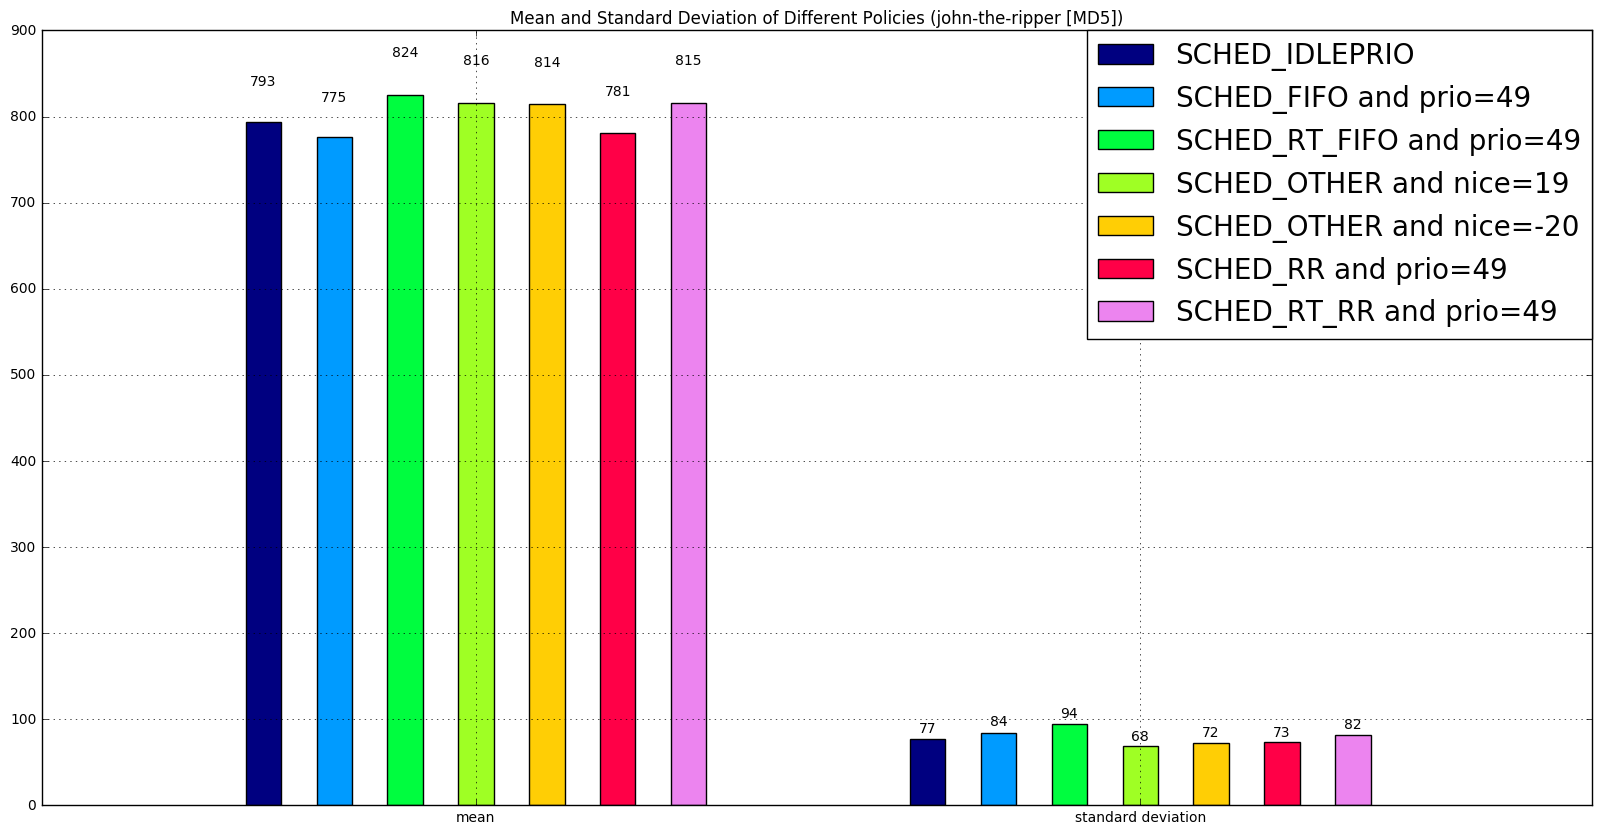

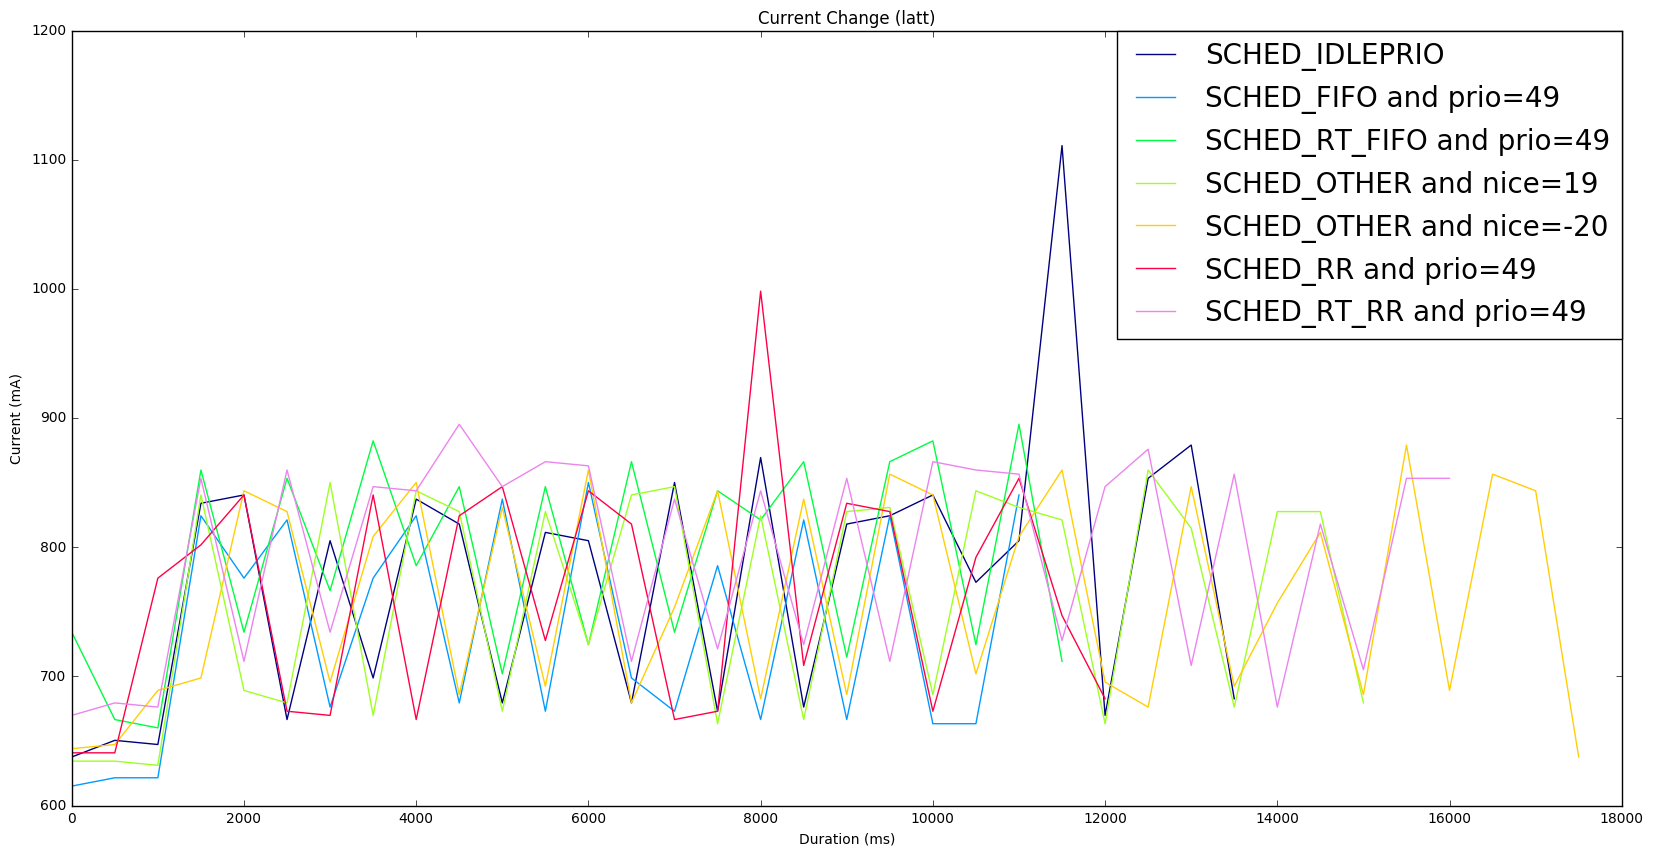

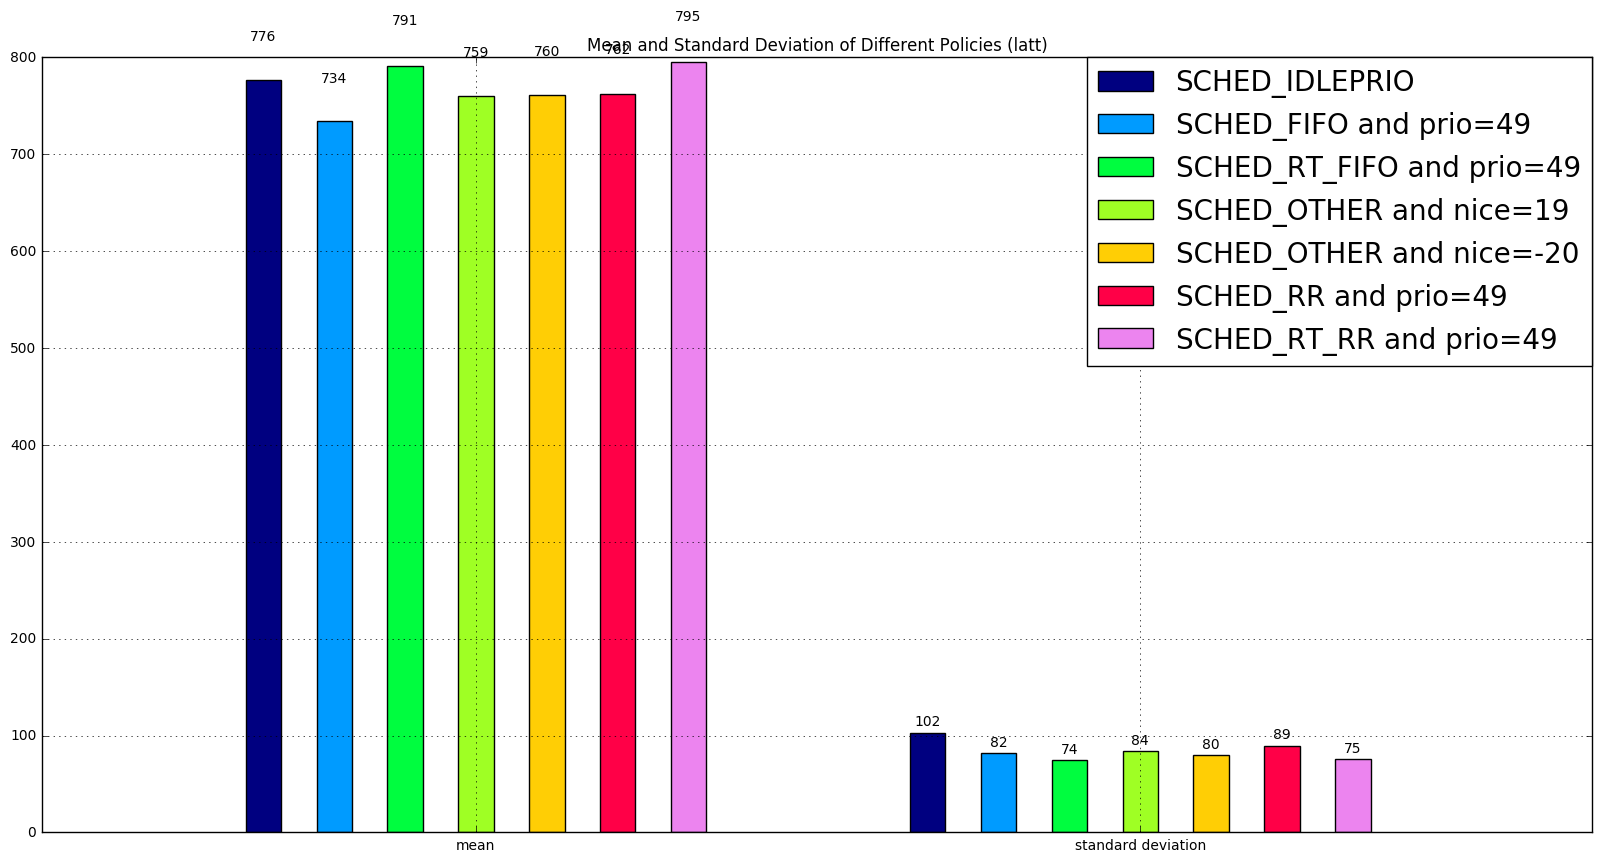

In [1]:
import re

import matplotlib.pyplot as plt
import numpy as np


def extract_currents(path_current, start, finish):
    with open(path_current, 'r') as f:
        currents = []
        prog = re.compile('\]\s*([\d\.]+)')
        started = False
        finished = False

        for line in f:
            if started and finish in line:
                finished = True
                break
                
            if start in line:
                started = True
            
            if started:
                m = re.search(prog, line)
                if m:
                    currents.append(float(m.group(1)))

        if not started or not finished:
            raise ValueError('Invalid start_time or finish_time')
        else:
            return currents

def extract_all_currents(path_time_slots, path_current):
    ## currents_of_benches: { identifier -> [policy] }
    ## policy: { currents -> [current], label -> policy name }
    currents_of_benches = {}
    
    bench_config_id = ''
    try:
        with open(path_time_slots, 'r') as f:
            for raw in f:
                line = raw.strip()
                if line:
                    # comments
                    if re.match(r'#', line):
                        continue
                    
                    # identifier of benchmark and configuration
                    m = re.search(r'\*\*\s(.+)$', line)
                    if m:
                        bench_config_id = m.group(1)
                        currents_of_benches[bench_config_id] = []
                        continue

                    comps = [c.strip() for c in line.split(',')]
                    if len(comps) != 3:
                        raise ValueError('Must be 3 components in time slot line: ' + line)

                    try:
                        currents = extract_currents(path_current, comps[0], comps[1])
                    except ValueError as err:
                        print('Invalid time slot: ' + line, err)
                        raise
                    
                    policy = {}
                    policy['currents'] = currents
                    policy['label'] = comps[2]
                    
                    if not bench_config_id:
                        raise NameError('No identifier for benchmark and configuration found before line: ' + line)

                    currents_of_benches[bench_config_id].append(policy)

        return currents_of_benches
    except IOError:
        print('File ' + path_time_slots + ' not exist.')

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.05 * height,
                '%d' % int(height),
                ha='center', va='bottom')

f_idx = 0
def new_figure():
    global f_idx
    plt.figure(f_idx, figsize=(20,10))
    f_idx += 1
    
def post_figure():
    plt.legend(loc=1, borderaxespad=0., prop={'size':20})

def plot(currents_of_benches, sample_rate):
    cmaps = None
    for bench_id, policies in currents_of_benches.items():
        if cmaps is None:
            # Have a look at the colormaps here and decide which one you'd like:
            # http://matplotlib.org/1.2.1/examples/pylab_examples/show_colormaps.html
            colormap = plt.cm.gist_ncar
            cmaps = [colormap(i) for i in np.linspace(0, 0.9, len(policies))]
        
        new_figure()
        max_length = max([len(p['currents']) for p in policies])
        x = np.arange(0, max_length * sample_rate, sample_rate)

        for idx, policy in enumerate(policies):
            currents = policy['currents']
            plt.plot(x[:len(currents)], currents, label=policy['label'], color=cmaps[idx])

        plt.title('Current Change (' + bench_id + ')')
        plt.ylabel('Current (mA)')
        plt.xlabel('Duration (ms)')
        post_figure()


        new_figure()
        labels = ('mean', 'standard deviation')
        ind = np.arange(len(labels)) * 15
        width = 0.8
        offset = width * 2
        for idx, policy in enumerate(policies):
            currents = policy['currents']
            rects = plt.bar(ind + offset * idx,
                            [np.mean(currents), np.std(currents)],
                            width,
                            label=policy['label'],
                            color=cmaps[idx],
                            align='center')
            autolabel(rects)

        plt.title('Mean and Standard Deviation of Different Policies (' + bench_id + ')')
        plt.xticks(ind + offset * (len(policies) - 1) / 2, labels)
        plt.grid(True)
        post_figure()
    
    
    plt.show()


PATH_TIME_SLOTS = './time_slots.txt'
PATH_CURRENT = 'log/current.log'
SAMPLE_RATE = 500    # In Milliseconds

# do plot
plot(extract_all_currents(PATH_TIME_SLOTS, PATH_CURRENT), SAMPLE_RATE)